In [1]:
import re
import string

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import learning_curve, StratifiedKFold

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kurti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, save_file=None, train_sizes=np.linspace(.1, 1.0, 5), scoring="f1"):
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 6))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    # get learning curve results
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,
                       scoring=scoring)
    # create means and standard deviations from train, test and fit times
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    
    if save_file:
        plt.savefig(f"images/{save_file}.png")
        
    plt.show()

In [24]:
def process_tweet(tweet):
    """
    Process tweet function.
    Input:
        tweet: a string containing a tweet
    Returns:
        tweets_clean: a list of words containing the processed tweet

    *Taken from Coursera NLP Specialization Course 1, week 1 programming
    assignment*
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', str(tweet))
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', str(tweet))
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', str(tweet))
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', str(tweet))
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return " ".join(tweets_clean)

In [25]:
# read train data
df = pd.read_csv("../inputs/train.csv")
# shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
# create new column "all_text"
df["all_text"] = df["text"] + df["keyword"] + df["location"]
# split into features and labels
X = df.drop(["text", "keyword", "location", "target"], axis=1)
y = df["target"]

# process tweets
X["all_text"] = X["all_text"].apply(process_tweet)
X.shape, y.shape

((7613, 2), (7613,))

In [26]:
X.head()

,id,all_text
0,3796,nan
1,3185,nan
2,7769,dt rt  ûïthe col polic catch pickpocket liver...
3,191,nan
4,9810,respons trauma children addict develop defens ...


In [27]:
# vectorize text 
vec = CountVectorizer()
X_vec = vec.fit_transform(X["all_text"].values)

# initialize classifier 
clf = MultinomialNB()

# initialize cross-validation 
skf = StratifiedKFold(n_splits=5, shuffle=False)

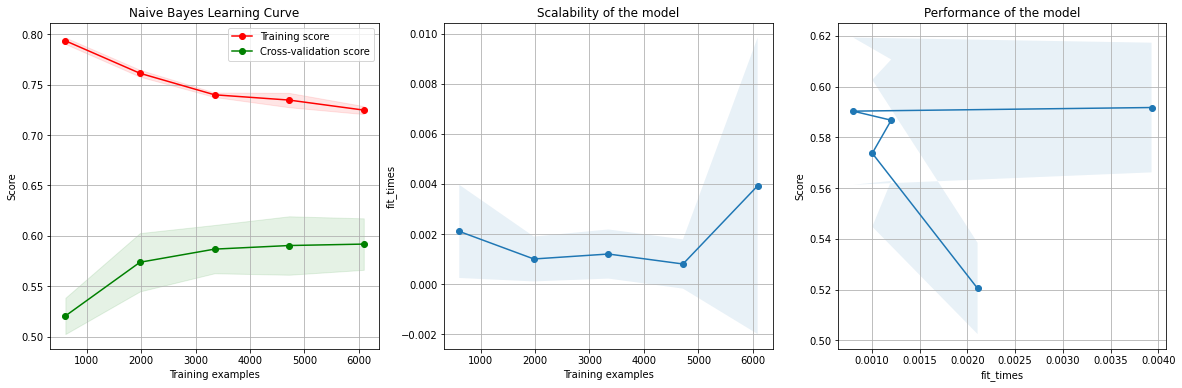

In [28]:
plot_learning_curve(estimator=clf, title="Naive Bayes Learning Curve", X=X_vec, y=y, axes=None, ylim=None, cv=skf,
                    n_jobs=None, save_file="incorrect_naive_bayes", train_sizes=np.linspace(.1, 1.0, 5), scoring="f1")

In [29]:
# new empty df 
X_new = pd.DataFrame()
# new features with correctly joined columns
X_new["all_text"] = df["text"] + df["keyword"].fillna("none") + df["location"].fillna("none")
# process tweets
X_new["all_text"] = X_new["all_text"].apply(process_tweet)
X_new.head()

,all_text
0,new weapon caus un-imagin destruct destructionnon
1,f @ing thing gishwh got soak delug go pad tamp...
2,dt rt  ûïthe col polic catch pickpocket liver...
3,aftershock back school kick great want thank e...
4,respons trauma children addict develop defens ...


In [30]:
# vectorize text
X_new_vec = vec.fit_transform(X_new["all_text"].values)

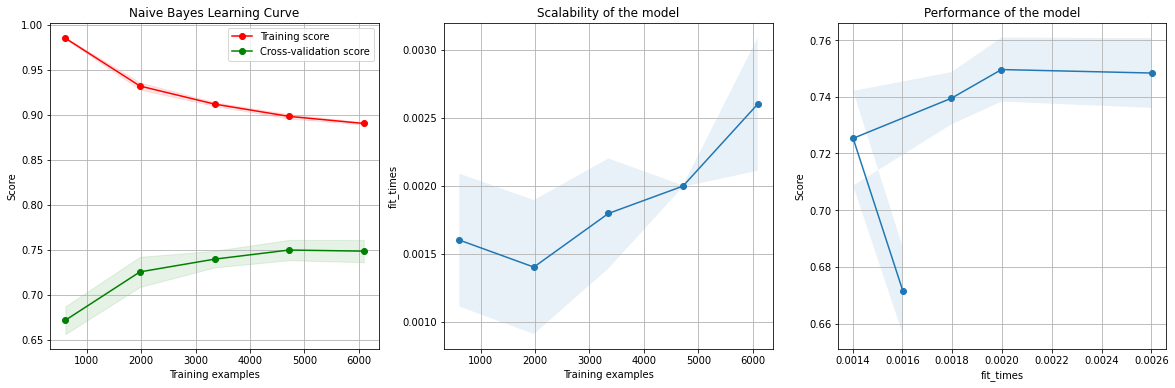

In [32]:
plot_learning_curve(estimator=clf, title="Naive Bayes Learning Curve", X=X_new_vec, y=y, axes=None, ylim=None, cv=skf,
                    n_jobs=None, save_file="fixed_df_naive_bayes", train_sizes=np.linspace(.1, 1.0, 5), scoring="f1")